In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

mb_size = 64
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device)

cuda


In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    

class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)


def reverseKL_STD(mu, sig): #KL(N(self.mu, self.sig) || N(0, I))
    reverse_kl = -torch.log(sig) + (sig * sig + mu * mu) / 2.0 - 0.5
    return torch.sum(reverse_kl, dim=1).mean()



In [0]:
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.layer = nn.Sequential(
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU()
        ).to(device)
        self.mean = torch.nn.Linear(1024, z_dim).to(device)
        self.log_var = torch.nn.Linear(1024, z_dim).to(device)

    def forward(self, x):
        x = self.layer(x)
        return self.mean(x), torch.exp(0.5 * self.log_var(x))

    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.layer = nn.Sequential(
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        return self.layer(x)
        

In [0]:
REG = []
REC = []
Q = Encoder(2)
P = Decoder(2)
Q_solver = optim.Adam(Q.parameters(), lr=1e-3)
P_solver = optim.Adam(P.parameters(), lr=1e-3)

In [0]:
num_epochs = 0
for epoch in range(num_epochs):
    epoch_loss = 0.0
    REC_AVG = 0.0
    REG_AVG = 0.0
    for X, _ in loader:
        X = X.to(device)
        Q_solver.zero_grad()
        P_solver.zero_grad()
        z_mu, z_sig = Q(X)
        Z = z_mu + z_sig * torch.randn_like(z_sig).to(device)
        # rec_loss = torch.sum(((P(Z) - X)**2).view(-1, 1), dim=1).mean()
        rec_loss = nn.functional.binary_cross_entropy(P(Z), X).to(device)
        reg_loss = reverseKL_STD(z_mu, z_sig)
        loss = rec_loss + 0.01 * reg_loss
        REC_AVG += rec_loss.item()
        REG_AVG += reg_loss.item()
        loss.backward()
        Q_solver.step()
        P_solver.step()
    REC.append(REC_AVG/len(loader))
    REG.append(REG_AVG/len(loader))
    print(REC[-1], REG[-1])

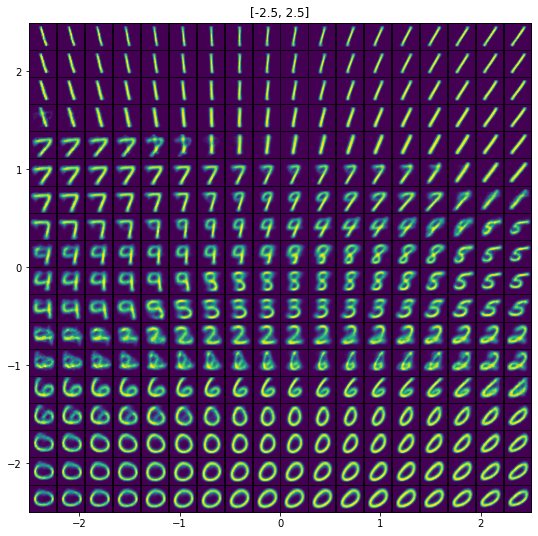

In [81]:
radius_range = 2.5
sqrt_num_img = 18
step = 2.0 * radius_range /sqrt_num_img
fig = plt.figure(figsize=(9, 9))
plt.title('[-2.5, 2.5]')
plt.axis((-2.5, 2.5, -2.5, 2.5))
n = 1.
for y in range(sqrt_num_img):
    for x in range(sqrt_num_img):
        X = -radius_range + step * x
        Y = radius_range - step * y
        data = np.array([X, Y], dtype=np.float32).reshape(1, -1)
        data = torch.from_numpy(data).to(device)
        img = P(data).cpu().data.numpy().reshape(28, 28)
        ax = fig.add_subplot(sqrt_num_img, sqrt_num_img, n, xticks=[], yticks=[])
        
        ax.imshow(img)
        n += 1
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()